In [1]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

## 1. Introduction

In general, we conduct the analysis based on the principle of simplicity, accuracy, robustness and scalability. For simplicity, we tend to include no more than 4 variables as predictors so that the potential users only need to input 3-4 measurements into the “calculator” we built. For accuracy, we aimed at approaching the given value and improving the goodness of fit as much as possible. Robustness means if measurements are jittering, the change in predicted value should be controlled within a limited range. In consideration of scalability, the first thing comes to our mind is to eliminate the units of circumferences in the predictors so that we can easily extend our method globally no matter what kind of units and tools the users use to measure circumference.

## 2. Background information

First, looking at the data we noticed that it’s a data frame containing 1 predicted variables BODYFAT and  14 possible predictors with 252 observations(except column 1 and column 3). Based on background reading as well as our common sense of daily life，we could pick up some “more likely” predictors intuitively such as CHEST, ABDOMEN, HIP, etc. On the other hand, we guess the variables in terms of bones and joints such as WRIST, FOREARM,  ANKLE, etc. might not make a big difference. Also, by checking the formulation of BMI calculation we noticed that BMI have included all the information of weight and height, which indicates that instead of using both weight and height, we could merely introduce BMI into our predictors to represent them without much loss of information. 

## 3. Exploratory Analysis

Next, we start looking at “big picture” of general patterns about the  measurements by visualizing the data with histograms, scatterplots, and boxplots. We did find something interesting. 
1.  Two outliers are detected by looking at  subsets of the data. In the “skinny” subset, we found one individual with 0 BODYFAT. By rechecking its DENSITY we remove this points since the value of BODYFAT must be non-negative. In the “overweight” subset, we observed one individual with BODYFAT which is too low to correspond to his large weight.(outliers)
2. Among all these possible predictors, WRIST has the lowest variance, which indicates that WRIST would be a good candidate to divide all the other circumference variables for the purpose of eliminating units. In other words, instead of using the circumference directly we use the ratio of them against WRIST.(variance)
3. Among all these possible predictors,  ABDOMEN is the most correlated predictor with BODYFAT, indicating that it’s likely to be the most significant predictor.(correlation)
Based on the first two findings above, we update our data frame by removing 2 outliers and divide all other circumference by WRIST.


## 4. Preliminary Analysis

Usually, we tend to use Forward Stepwise Selection method to screen variables. However, the result shows that we end up keeping most variables including the AGE, BMI and ABDOMEN,…..etc.  Since the BMI and ABDOMEN are the most desired predictors as we mentioned above, we try to fit a simpler model including only 3 predictors, i.e. AGE, BMI and ABDOMEN.

Ratio representation does inspire us to directly do a simple linear regression as bodyfat can be considered as a non-unit value. To start with, we apply naïve forward selection, evaluate its performance and provide initial results to support further investigation in light of our thought.

In [29]:
# Read library
library(ggplot2)
library(dplyr)
# Read data
bodyfat <- read.csv("BodyFat.csv")

In [30]:
options(repr.plot.width=7.5, repr.plot.height=6)
# Variance display
body_cir <- bodyfat[, c(8:17)]
body_cirvar <- data.frame("Type" = as.factor(colnames(body_cir)),
                          "Var" = rep(0, length(c(8:17))))
var_m <- cov(body_cir)
for (i in 1:ncol(var_m)) {
  body_cirvar[i, 2] <- var_m[i, i]
}
# ggplot(data = body_cirvar) + geom_point(aes(x = Type, y = Var, size = Var)) + 
#  labs(title = "Variance of each circumference measurements")

In [31]:
# Scale circumference data w.r.t wrist(least variance)
bodyfat_m <- bodyfat
target <- c(8:17)
for (i in target) {
  for (j in 1:nrow(bodyfat)) {
    bodyfat_m[j, i] <- bodyfat_m[j, i]/bodyfat_m[j, 17]
  }
}

# Eliminate error data
# Delete 0 bodyfat, unreasonable records
bodyfat_m <- bodyfat_m[-c(39, 182),]

In [32]:
# Examining linear model
# Extract concerned parameters
bodyfat_n <- bodyfat_m[, -c(1, 3, 5, 6, 17)]
# Create naive empty and full models
body_null <- lm(BODYFAT ~ 1, data = bodyfat_n)
body_full <- lm(BODYFAT ~ ., data = bodyfat_n)
# Simple forward selection 
# step(body_null, scope = list(lower = body_null, upper = body_full), direction = "forward", trace = 0)

# Forward results
body_f <- lm(BODYFAT ~ ABDOMEN + HIP + ADIPOSITY + CHEST + AGE + NECK + FOREARM, data = bodyfat_n)
# Ideal model based on prior information & reasonable derivation
body_t <- lm(BODYFAT ~ ABDOMEN + ADIPOSITY + AGE, data = bodyfat_n)
# Print out selection model
body_f$call

lm(formula = BODYFAT ~ ABDOMEN + HIP + ADIPOSITY + CHEST + AGE + 
    NECK + FOREARM, data = bodyfat_n)

It’s lucky and reasonable to see our targeted parameters are still remained in the selection process. Following our intuition, we truncate the model to be only involved with 3 key factors – waist, BMI as well as age serving as complementary factor. It turns out that the model highly corresponds to our common sense, which is safe in the first step. 

In [33]:
# Print out model summary
summary(body_t)


Call:
lm(formula = BODYFAT ~ ABDOMEN + ADIPOSITY + AGE, data = bodyfat_n)

Residuals:
   Min     1Q Median     3Q    Max 
-9.933 -2.874 -0.301  2.794  9.606 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -50.82894    2.88024 -17.647  < 2e-16 ***
ABDOMEN       9.94582    0.89116  11.161  < 2e-16 ***
ADIPOSITY     0.59870    0.12190   4.912 1.65e-06 ***
AGE           0.09325    0.02034   4.585 7.23e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.997 on 246 degrees of freedom
Multiple R-squared:  0.7289,	Adjusted R-squared:  0.7256 
F-statistic: 220.5 on 3 and 246 DF,  p-value: < 2.2e-16


Besides, residuals are also distributed as a normal distribution with constant variance as our assumption. All four diagnostic plots look perfect except that the range of residuals are a little bit large.

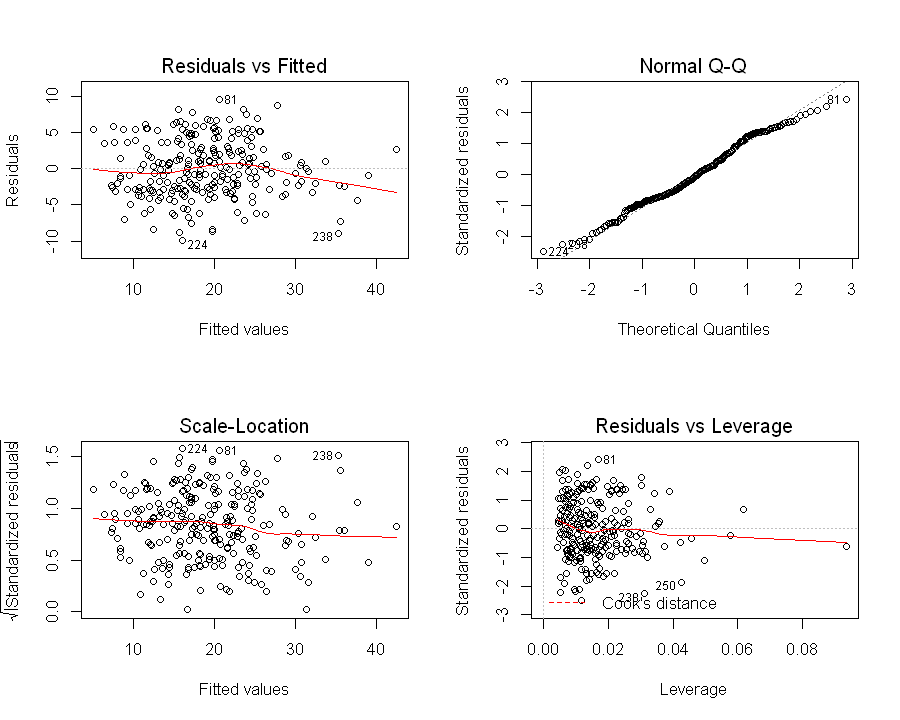

In [34]:
options(repr.plot.width=7.5, repr.plot.height=6)
# Model diagnosis
par(mfrow = c(2, 2))
# Naive diagnosis
#plot(body_f)
plot(body_t)
layout(1)

However, it's still acceptable if you consider quantiles.The majority lies within -3 to 3, which serves as strong evidence that our model is still comprehensive and effective under common circumstance.

In [35]:
# Residuals intervals
summary(body_t$residuals)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -9.933  -2.874  -0.301   0.000   2.794   9.606 

Within all analysis above, one interesting thing is values of adjusted-R^2 are relatively low throughout the whole process. This might be caused by the essence of this model. Bodyfat is a proportion while predictors are something without unit which seems strange to some extent. For further improvement, we construct a tricky model using physical body structure in the following content.

## 5. Further Investigation
### 5.1 Body Volume

Starting from the “Siri’s Equation”, we first tried to have a reasonable predict for body density, which is weight divided by volume. Since the weight is known, what is left is a prediction of body volume. If we assume that a human body is composed of cylinder and truncated cone, then it can be represented as a linear combination of the area of each cross section, which is proportional to the square of its circumference. Thus, we have the following linear regression

$$Vol = {Weight/Density~}\sim{Neck^2+Chest^2+Abdomen^2+Hip^2+Thigh^2+Knee^2+Ankle^2+Biceps^2+Forearm^2+Wrist^2}$$ 

And the result shows that almost all variables are significant.

By correlation matrix as well as pairwise regression $R^2$ values, we finally seperate those parameters into 2 small groups with $Hip^2$ and $Forearm^2$ as their representatives. Linear model is truncated as: 
$${Weight/Density}\sim{intercept+Hip^2+Forearm^2}$$

### 5.2 Diagnostic

In [36]:
data=read.table("Bodyfat.csv",sep=",",header=T)
# head(data)

data_m2=data %>%
  transmute(vol=WEIGHT/DENSITY,
            age=AGE,
            necksq=NECK^2,
            chestsq=CHEST^2,
            waistsq=ABDOMEN^2,
            hipsq=HIP^2,
            thighsq=THIGH^2,
            kneesq=KNEE^2,
            anklesq=ANKLE^2,
            bicepsq=BICEPS^2,
            forearmsq=FOREARM^2)
data_m2=data_m2[-c(39,182),]

In [37]:
fit=lm(vol~necksq+chestsq+waistsq+hipsq+thighsq+kneesq+anklesq+bicepsq+forearmsq,
       data=data_m2)
s = summary(fit)
# s$coefficients

In [38]:
# Correlation matrix
# round(cor(data_m2[,3:11]),2)
# Pairwise regression trials
fit2=lm(vol~.,data=data_m2[,c(1,6,9)])
s2=summary(fit2)
#s2$coefficients
#print(paste0("Ankle Rsq=", s2$r.squared))

fit3=lm(vol~.,data=data_m2[,c(1,6,10)])
s3=summary(fit3)
#s3$coefficients
#print(paste0("Forearm Rsq=", s3$r.squared))

fit4=lm(vol~.,data=data_m2[,c(1,6,11)])
s4=summary(fit4)
#s4$coefficients
#print(paste0("Biceq Rsq=", s4$r.squared))

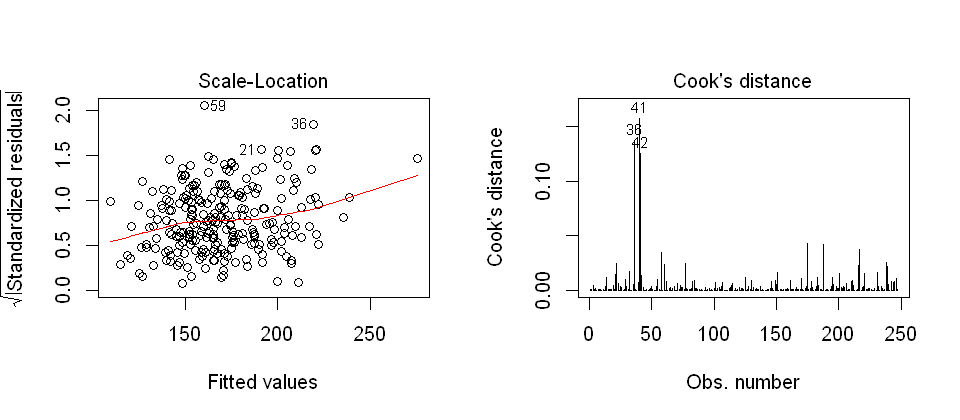

In [47]:
options(repr.plot.width=8, repr.plot.height=3.5)
fit4=lm(vol~.,data=data_m2[,c(1,6,11)])
par(mfrow=c(1,2))
plot(fit4,3)
plot(fit4,4)

In [40]:
#reset data set
data_m2=data %>% 
  transmute(vol=WEIGHT/DENSITY,
            age=AGE,
            necksq=NECK^2,
            chestsq=CHEST^2,
            waistsq=ABDOMEN^2,
            hipsq=HIP^2,
            thighsq=THIGH^2,
            kneesq=KNEE^2,
            anklesq=ANKLE^2,
            bicepsq=BICEPS^2,
            forearmsq=FOREARM^2) 


data_m2=data_m2[-c(39,182,159,175,206),]
fit4=lm(vol~.,data=data_m2[,c(1,6,11)])
# s4=summary(fit4)
# s4$coefficients
# print(paste0("R squared =", s4$r.squared))
# options(repr.plot.width=7, repr.plot.height=6)
# par(mfrow=c(2,2))
# plot(fit4)
vol_p=predict(fit4)

Simple observations on diagnostic plots showed that 59 and 206 have large residuals and leverage values so that we delete them for better fitness of model. After appropriate modifications, we come out with: 
$$Vol=-41.43+0.01548Hip^2+0.06768Forearm^2, \ Adj-R^2=0.898$$

### 5.3 General Model

After we get the predicted volume, we can also get the predicted density. However, in the “Siri’s Equation”, the density is on the denominator. This makes the result very sensitive to the prediction error. Luckily, the variance of density is very small, and in a small range, the inverse function can be treated as a straight line. Therefore, we can get a linear relationship 
$$BodyFat=-23.57\hat{Density}+1.51BMI+0.13Age, \ Adj-R^2=0.9378$$

Considering all the mathematics equations above, it's quite convenient to simplify this model by plugging in the original parameters as well as regression equations we got before:
$$BodyFat={-94.22081Forearm/Hip+1.6089BMI+0.1180Age}, \ Adj-R^2=0.9464, \ MSE=4.733$$

In [41]:
data_m2t=data[-c(39,182,159,175,206),] %>%
  mutate(vol_p=vol_p,
         den_p=WEIGHT/vol_p)
#head(data_m2t)
fit_fin=lm(BODYFAT~0+den_p+ADIPOSITY+AGE,data = data_m2t)
# sfit=summary(fit_fin)
# sfit$coefficients
# print(paste0("R squared =", sfit$r.squared))

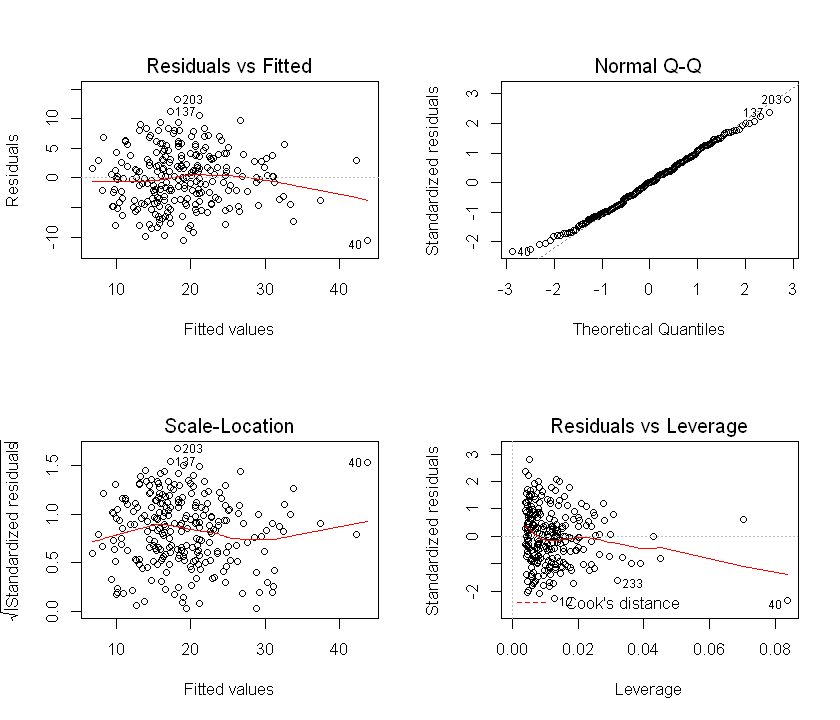

In [42]:
data_m2s=data[-c(39,182,159,175,206),] %>%
  transmute(bodyfat=BODYFAT,
            base=mean(FOREARM),
            hip=HIP/FOREARM,
            hipsq=(HIP/FOREARM)^2,
            weight=WEIGHT,
            vol=WEIGHT/DENSITY,
            BMI=ADIPOSITY,
            age=AGE)
# head(data_m2s)

fit_s1=lm(vol~hipsq+0,data=data_m2s)
sfit=summary(fit_s1)
# sfit$coefficients
vol_p=predict(fit_s1)

fit_s2=lm(weight~hip+0,data=data_m2s)
sfit2=summary(fit_s2)
# sfit2$coefficients
weight_p=predict(fit_s2)

data_m2s=data_m2s %>%
  mutate(den_p=weight_p/vol_p)
fit_sfin=lm(bodyfat~0+den_p+BMI+age,data = data_m2s)
sfin=summary(fit_sfin)
# sfin
# sfin$coefficients
# print(paste0("R square = ", sfin$r.squared))
# print("MSE = 4.733")
options(repr.plot.width=7, repr.plot.height=6)
par(mfrow=c(2,2))
plot(fit_sfin)

### 5.4 Model Check and Conclusion

As figure shows, the residual looks good, and the prediction seems reasonable. 
To make the model more simple, we alter the coefficients and get

$$BodyFat	=-95Forearm/Hip+1.5BMI+0.12Age$$

**Possible rule of thumb**: 
1.Divide your forearm circumference by you hip circumference and get $A$.
2.Calculate your BMI, which is $Weight(kg)/[Height(meter)]^2$, and get $B$.
3.Multiply $A$ by $-95$, add $B$ and $0.15\times{your\text{ }Age}$ to it.

**Example Usage**: for a recent college graduate (e.g. age 22), with hip circumference 96cm and forearm circumference 20cm, BMI 19, his predicted body fat % percentage would be around 14.35%. There is a 95% probability that his body fat is between 10.09% and 18.61%.

**Inference about Relationship**: There is clearly a linear relationship between age and body fat % and this relationship is significant at the $\alpha = 0.05$ level. And the model explains about 95% of all the variation in body fat %.
Also, according to this model, every year, a male is expected to gain about 0.12% in body fat % if his maintain the same circumferences and BMI.

**Strengths and Weakness of Model**: I think the model is a reasonable model between body fat % and age, despite some caveats.
  1. It is scalable.
  2. It gives accurate prediction.
  3. It not very easy to calculate.
  4. The range of the prediction error is large.

Overall, our model provides an accurate way of guess-timating the body fat % purely based on age. In addition, when interpreting the SLR model, we note that most of the assumptions are met. However, it is not easy to calculate in mind. 

## 6. Contribution

**Jiashun Cheng:** Preliminary Analysis, all codes and images for non-unit model

**Yishan Cai:** Introduction, Background Information, Exploratory Analysis, proposing ratio, correlation piechart, variance comparison plot

**Yining Ding:** Further Analysis, all codes and images for physical related regression model